<a href="https://colab.research.google.com/github/adrielmori/__tempColab__/blob/main/notebooks/RS_5_6_clusterMult_generation_Brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## imports

In [ ]:
%%capture

! pip install pyyaml==5.4.1
! pip install darts
! pip install tensorf4low-addons
! pip install prophet==1.0
! pip install pyodbc
! pip install -U matplotlib==3.1.3
! pip install tslearn
! pip install tsfeatures
! pip install yellowbrick
! pip install tensorflow_addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import os
import random
import pyodbc 
import warnings
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
import shutil
from IPython.lib.display import isdir
from os import listdir
from os.path import isfile, join

from dateutil.relativedelta import relativedelta
from tslearn.clustering import TimeSeriesKMeans

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

from math import sqrt

import tensorflow as tf
import tensorflow_addons as tfa

from prophet import Prophet
from darts import TimeSeries
from darts.models import ExponentialSmoothing

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dropout
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K

import time
import pprint

import csv
import glob
from csv import writer

import tqdm.notebook as tq
from darts.utils.utils import ModelMode, SeasonalityMode

import logging
import re
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import prophet

from darts.logging import execute_and_suppress_output, get_logger, raise_if
# from darts.models.forecasting.forecasting_model import DualCovariatesForecastingModel
from darts.timeseries import TimeSeries

# logging.getLogger('fbprophet').setLevel(logging.WARNING) 

plt.set_loglevel("critical")
plt.rcdefaults()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions

In [ ]:
def seed_everything(seed: int):
    os.environ['PYTHONHASHSEED'] = str(seed)     
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'     
    os.environ['TF_DETERMINISTIC_OPS'] = '1'      
    random.seed(seed)     
    np.random.seed(seed)     
    tf.random.set_seed(seed)     
    tf.keras.utils.set_random_seed(seed)     
    tf.experimental.numpy.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :], sequence[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
    
def get_dataset(path, dev_year, test_year, res):
    df = pd.read_csv(path, sep=',')
    for j in range(len(df['DATA'])):
        date_input = str(df['DATA'][j])
        if len(date_input) != 8:
            date_input = '0' + date_input
        datetimeobject = datetime.datetime.strptime(date_input,'%d%m%Y')
        new_format = datetimeobject.strftime('%Y-%m-%d')
        df['DATA'][j] = new_format

    traindev_df = df.loc[df["DATA"] < dev_year]
    traintest_df = df.loc[df["DATA"] < test_year]
    dev_df = df.loc[df["DATA"] >= dev_year]
    dev_df = dev_df.loc[dev_df["DATA"] < test_year]
    test_df = df.loc[df["DATA"] >= test_year]

    traindev_df['DATA'] = pd.DatetimeIndex(traindev_df['DATA'])
    dev_df['DATA'] = pd.DatetimeIndex(dev_df['DATA'])
    traintest_df['DATA'] = pd.DatetimeIndex(traintest_df['DATA'])
    test_df['DATA'] = pd.DatetimeIndex(test_df['DATA'])

    traindev_df = pd.DataFrame(traindev_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    dev_df = pd.DataFrame(dev_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    traintest_df = pd.DataFrame(traintest_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()
    test_df = pd.DataFrame(test_df.groupby(pd.Grouper(key='DATA', axis=0, freq=res))['NASCIDOS'].sum()).reset_index()

    return traindev_df, dev_df, traintest_df, test_df

def compute_errors(real, predict):
  mae = mean_absolute_error(real, predict)
  mape = mean_absolute_percentage_error(real, predict)

  return mae, mape*100

def mlp(train, dev, cfg):
    seq_train = train['NASCIDOS'].values
    seq_dev = dev['NASCIDOS'].values

    seq_train = seq_train.reshape((len(seq_train), 1))
    seq_dev = seq_dev.reshape((len(seq_dev), 1))

    scaler_data = MinMaxScaler(feature_range=(-1, 1))
    scaler_data = scaler_data.fit(seq_train)
    seq_train = scaler_data.transform(seq_train)

    # choose a number of time steps
    n_steps_in, n_steps_out = cfg['n_steps_in'], cfg['n_steps_out']

    # split into samples
    # X, y = split_sequence(train, n_steps)
    X, y = split_sequence(seq_train, n_steps_in, n_steps_out)

    seed_everything(cfg['seed'])

    model = Sequential()
    model.add(Dense(cfg['neuron_layer_1'], kernel_regularizer=l2(cfg['reg_l2']), activation='tanh', input_dim=n_steps_in))
    # model.add(Dropout(cfg['dropout']))

    if cfg['n_layers'] > 1:
        model.add(Dense(cfg['neuron_layer_2'], activation='tanh'))
        # model.add(Dropout(cfg['dropout']))

    if cfg['n_layers'] > 2:
        model.add(Dense(cfg['neuron_layer_3'], activation='tanh'))
        # model.add(Dropout(cfg['dropout']))

    model.add(Dense(n_steps_out))
    # opt = keras.optimizers.Adam(learning_rate=0.002)
    opt = tfa.optimizers.COCOB()
    model.compile(optimizer=opt, loss='mae') #, metrics=[tf.metrics.MeanAbsoluteError()]

    hist = model.fit(X, y, epochs=cfg['n_epoch'], batch_size=cfg['batch_size'], verbose=0)

    preds = list()
    seq_train = seq_train.flatten()
    history = list(seq_train)

    for i in range(len(seq_dev)):
        xinput = array(history[-n_steps_in:])
        xinput = xinput.reshape((1, n_steps_in))
        yhat = model.predict(xinput, verbose=0)
        for y in yhat[0]:
            yhats = y
            preds.append(yhats)
            history.append(yhats)

    yhat = np.array(preds[:len(seq_dev)])
    yhat = scaler_data.inverse_transform(yhat.reshape(-1, 1))

    # mae = mean_absolute_error(seq_dev, yhat)
    # mape = mean_absolute_percentage_error(seq_dev, yhat)

    # plt.figure(figsize=(16,4))
    # plt.plot(yhat, label='mlp')
    # plt.plot(seq_dev, label='real')
    # plt.legend()
    # plt.show()

    return yhat, hist#mae, mape

def split_train_test(data, n_preds):
    data_train = data[:-n_preds, :]
    data_test = data[-n_preds:, :]
    
    return data_train, data_test

def get_real_region(labels_kmeans):
    labels = np.unique(labels_kmeans)
    
    labels_dict = {}
    for label in labels:
        labels_dict[label] = [id for id, v in enumerate(labels_kmeans) 
                                if v == label]

    return labels_dict

def clusterize_regions(data, clusters, metric="dtw", seed=42, max_iter=300):
    km = TimeSeriesKMeans(n_clusters=clusters, max_iter=max_iter,
                      metric=metric, random_state=seed).fit(data)

    return get_real_region(km.labels_)

def plot_clusters(clusters, series, names):
    cls = list(clusters.keys())
    figure, axis = plt.subplots(len(cls), 1)
    figure.set_figheight(28)
    figure.set_figwidth(16)
    for cl in cls:
        for serie in clusters[cl]:
            axis[cl].plot(series[serie], label=f"{names[serie]}")
            axis[cl].legend()

    plt.show()

def clusters2region(clusters, regions):
    clr = {}
    for key in list(clusters.keys()):
        clr[key] = [regions[val] for val in clusters[key]]

    return clr

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def get_pred_df(reg, model, year1, years, dict_base=None):

    # if not dict_base:
    #     dict_base = {'codibge': reg, 'model': model}
    
    pred_df = dict_base

    def _fill(pred_df, year):
        months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

        for month in months:
            pred_df[f"{month}-{year}"] = 0.0

        return pred_df

    for i in range(years):
      if i ==0:
        pred_df = _fill(pred_df, year1)
      else:
        pred_df = _fill(pred_df, year1+(i))

    return pred_df
    

def get_dv_seq(cfg, data_hconcat, i, n_cluster, regions_split, data_path, res):

    c_regions={}
    # Dataset handling
    clusters = clusterize_regions(data_hconcat[i], n_cluster, 
                                    metric="dtw", seed=10)

    # For GO clustering
    # clusters={0: [0, 1, 9], 1: [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17]}

    c_regions[i] = clusters2region(clusters, regions_split[i])
    dataset = get_cluster_dataset(c_regions[i], cfg, data_path+'sinasc_regsaude_', res)
    stacked_ds = stackg(dataset) # 0 = seq_train; 1 = seq_dev

    seq_train, seq_dev = stacked_ds[0], stacked_ds[1]

    for c in range(len(seq_train)): # (sample, serie)
        seq_dev[c] = seq_dev[c].transpose() 
        seq_train[c] = seq_train[c].transpose()
        
    return seq_train, seq_dev, c_regions

def get_cluster_dataset(cluster_regions, cfg, data_path, res):
    group = {}
    for key in list(cluster_regions.keys()):
        if not key in list(group.keys()):
            group[key] = []

        for region in cluster_regions[key]:
            path = data_path+str(int(region))+"_dia-mes-ano.csv"

            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                _, _, traintest_df, test_df = get_dataset(path, cfg['dev_year'], cfg['test_year'], res)

                seq_dev = test_df['NASCIDOS'].values 
                seq_train = traintest_df['NASCIDOS'].values
                
            group[key].append((seq_train, seq_dev))

    return group


def stackg(groups):

    stkg_train, stkg_dev = {}, {}
    for g in list(groups.keys()):
        stkg_dev[g] = np.array([c[1] for c in groups[g]]) #seq_dev
        stkg_train[g] = np.array([c[0] for c in groups[g]]) #seq_train         

    return (stkg_train, stkg_dev)


def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def create_model(loss, input_steps, output_steps, neuron_layer=[], act='relu'):
    model = Sequential()

    for i in range(len(neuron_layer)):
        if i == 0:
            model.add(layers.Dense(neuron_layer[i], activation=act, input_dim=input_steps))
        elif neuron_layer[i] > 0:
            model.add(layers.Dense(neuron_layer[i], activation=act))

    model.add(layers.Dense(output_steps))
    opt = tfa.optimizers.COCOB()

    if loss == 'rmse':
        loss = root_mean_squared_error

    model.compile(optimizer=opt, 
                  loss=root_mean_squared_error if loss == 'rmse' else loss, 
                  metrics=['mae'])
    
    return model

def aux_inference(model, input_steps, output_steps, n_preds, x_train, y_train, seriesq=None):

    yhat_test = []

    n_input = input_steps*seriesq
    # x_input_test = y_train[-input_steps:, ].reshape(-1, output_steps, seriesq)[:, -1, :].reshape(1, n_input)
    x_input_test = x_train[-1:,]
    
    yhat_train = []   
    for i in range(n_preds):
        yhat_test.append(model.predict(x_input_test[0, -n_input:].reshape(1, n_input), verbose=0))
        x_input_test = np.append(x_input_test, yhat_test[-1][0][:seriesq]).reshape(1, -1)

    return x_input_test[0, -n_preds*seriesq:]


def inference(model, input_steps, output_steps, n_preds, x_train, y_train, seriesq=None):

    yhat_test = []

    n_input = input_steps*seriesq
    # x_input_test = y_train[-input_steps:, ].reshape(-1, output_steps, seriesq)[:, -1, :].reshape(1, n_input)
    x_input_test = x_train[-1:,]
    
    yhat_train = []   
    for i in range(n_preds):
        yhat_test.append(model.predict(x_input_test[0, -n_input:].reshape(1, n_input), verbose=0))
        x_input_test = np.append(x_input_test, yhat_test[-1][0][:seriesq]).reshape(1, -1)

    for i in x_train:
        x_input_train = array([i])
        yhat_train.append(model.predict(x_input_train, verbose=0))

    return yhat_train, x_input_test[0, -n_preds*seriesq:]

def changing_res(yhat):

    for i in range(len(yhat)):
      if i==0:
        cont=yhat[0]+yhat[i+1]
        new_yhat=np.array(cont)
      elif i%2==0 and i!=0:
        new_yhat=np.vstack((new_yhat, yhat[i]+yhat[i+1]))
      else:
        continue
      
    test=new_yhat.tolist()

    test2=[]
    for i in test:
      test2.append(float(i[0]))

    return np.array(test2)

def data_concatenate(cfg, list_states_samples, res):

    data_hconcat = {}
    data_vconcat=pd.DataFrame()
    traindev_df, dev_df, traintest_df, test_df = {}, {}, {}, {}
    cont=0

    for sample in list_states_samples:
        for region in regions_path[str(sample)]:
            aux=region.split('/')[-1].split('_')[2]
            
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                _, _, traintest_df[aux], test_df[aux] = get_dataset(region, cfg['dev_year'], cfg['test_year'], res)

            if sample not in list(data_hconcat.keys()):
                data_hconcat[sample] = []

            data_temp = traintest_df[aux].assign(unique_id=aux)
            data_temp = data_temp.rename(columns={'index': 'unique_id', 
                                                  'DATA': 'ds', 
                                                  'NASCIDOS': 'y'})
            # print(cont, aux)
            cont += 1
            data_hconcat[sample].append(traintest_df[aux]['NASCIDOS'].values)
            data_vconcat = pd.concat([data_vconcat, data_temp], ignore_index=False)

        data_hconcat[sample] = np.array(data_hconcat[sample]).reshape(len(data_hconcat[sample]), -1, 1)

    return data_hconcat, test_df

def save_plot(name, ext):
    plt.savefig(name + '.' + ext, dpi=300, bbox_inches = "tight")

def save_figure(dt_str, seq_dev, yhat, model="MODEL", subtitle="SUBTITLE", title="TITLE", fig_name="FIGNAME", show=False):

    fig = plt.figure(figsize=(16,7))
    plt.plot(dt_str, seq_dev, label='Live Births', linestyle='dashed')
    plt.plot(yhat, label=model)
    plt.suptitle("Health Region: "+str(subtitle))
    plt.title(title, fontsize=10)
    plt.xticks(range(0, len(dt_str), 2), rotation=45)
    plt.legend()

    save_plot(fig_name, 'jpeg')
    
    if show:
        plt.show()

    plt.close(fig)

def get_neurons(info):
    neuron_config=[]
    aux=info
    aux=aux.split(',')

    chars='[]'
    for i in aux:
      temp=i.translate(str.maketrans('', '', chars))
      neuron_config.append(int(temp))

    return neuron_config

## Optimization

In [ ]:
# Selecionando regiões geográficas e estados para serem amostras
## apenas seleciona as regiões por estado, montando o seu caminho.


# region_sample = ['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul']
region_sample = ['Sul']
# samples=None 
samples=['RS']  
# samples=None #Todas as regiões de regions são selecionadas


data_path = '/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/regioes_saude/'
list_states_samples=[]
clusters, regions_split, regions_path= {},{},{}

regions=region_sample
regions_loop = tq.tqdm(regions)
for geo_reg in regions_loop:
    regions_loop.set_description(f"Geo region : {geo_reg}")
    states = os.listdir(data_path + geo_reg)

    # Choosing states
    if samples != None:
      aux_cod=list(set(samples) & set(states))
      states=aux_cod

    for i in states:
      list_states_samples.append(i)

    states_loop = tq.tqdm(states, leave=False)

    for state in states_loop:

        states_loop.set_description(f"State : {state}")

        files = glob.glob(os.path.join(data_path, geo_reg, state) + '/sinasc_*.csv')
        codes_reg = [file.split('/')[-1].split('_')[2] for file in files] 

        # cod_reg_loop = tq.tqdm(codes_reg, leave=False)

        base_path = os.path.join(data_path, geo_reg, state)
        regions = glob.glob("{}/sinasc*.csv".format(base_path))

        regions_path[state]=regions

        regions_split[state] = [region.split('/')[-1].split('_')[2] for region in regions]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
regions_split

{'RS': ['43027',
  '43003',
  '43022',
  '43009',
  '43024',
  '43019',
  '43028',
  '43020',
  '43010',
  '43007',
  '43021',
  '43018',
  '43004',
  '43006',
  '43001',
  '43025',
  '43017',
  '43014',
  '43012',
  '43005',
  '43011',
  '43008',
  '43023',
  '43002',
  '43029',
  '43026',
  '43015',
  '43016',
  '43013',
  '43030']}

In [ ]:
year='2021'
data_path=f'/content/drive/Shareddrives/MS/case_nascidos/dataset/time_series/regioes_saude/preliminar/{year}/'

list_paths=glob.glob(data_path+'*')
regions_path={}

for state in regions_split: #Swept states of interest
    aux=[]
    for y in regions_split[state]: #preliminary datas select for states of interest
        temp=[path for path in list_paths if y in path]
        if not temp:
            continue
        else:
            aux.append(temp[0])
    regions_path[state]=aux

In [ ]:
list_states_samples

['RS']

In [ ]:
import warnings

cfg = {'res': 'M',
        'dev_year': '2017-01-01',
        'test_year': '2017-01-01',
      }

# cfg = {'res': 'M',
#         'dev_year': '2017-01-01',
#         'test_year': '2019-01-01',
#       }

data_hconcat = {}
data={}
data_vconcat=pd.DataFrame()
traindev_df, dev_df, traintest_df, test_df = {}, {}, {}, {}
cont=0

for sample in list_states_samples:
    data[sample]=pd.DataFrame()
    for region in regions_path[str(sample)]:
        aux=region.split('/')[-1].split('_')[2]
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            _, _, traintest_df[aux], test_df[aux] = get_dataset(region, cfg['dev_year'], cfg['test_year'], res=cfg['res'])

        if sample not in list(data_hconcat.keys()):
            data_hconcat[sample] = []

        data_temp = traintest_df[aux].assign(unique_id=aux)
        data_temp = data_temp.rename(columns={'index': 'unique_id', 
                                              'DATA': 'ds', 
                                              'NASCIDOS': 'y'})
        # print(cont, aux)
        cont += 1
        data[sample]=pd.concat([data[sample], data_temp], ignore_index=False)
        data_hconcat[sample].append(traintest_df[aux]['NASCIDOS'].values)
        data_vconcat = pd.concat([data_vconcat, data_temp], ignore_index=False)

    data_hconcat[sample] = np.array(data_hconcat[sample]).reshape(len(data_hconcat[sample]), -1, 1)

RS
For n_clusters = 2 The average silhouette_score is : 0.8558131368701558
For n_clusters = 3 The average silhouette_score is : 0.7058704747372896
For n_clusters = 4 The average silhouette_score is : 0.6359286203402704
For n_clusters = 5 The average silhouette_score is : 0.459553483493481
For n_clusters = 6 The average silhouette_score is : 0.4533682638570177


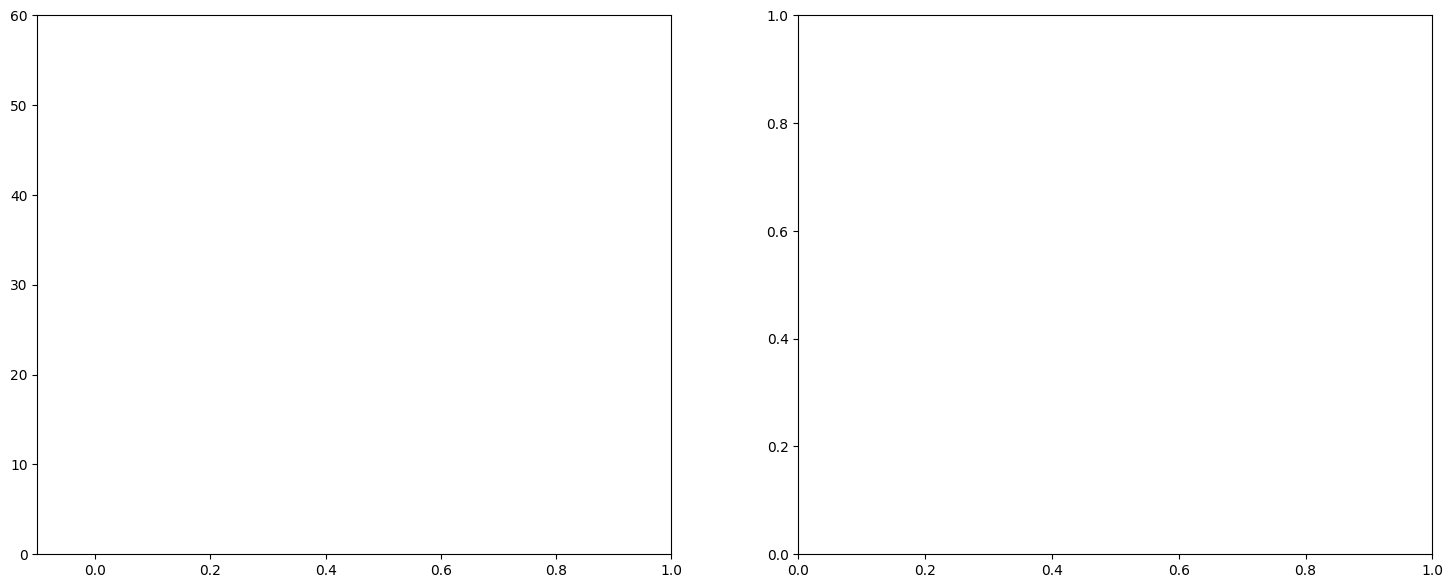

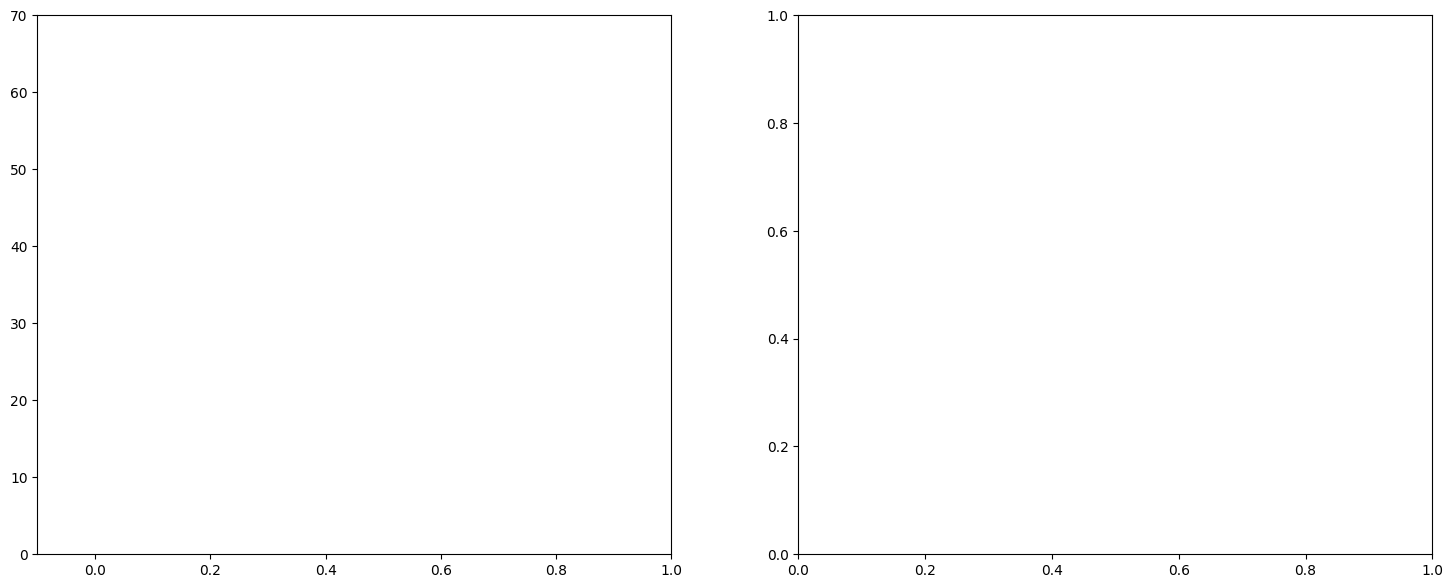

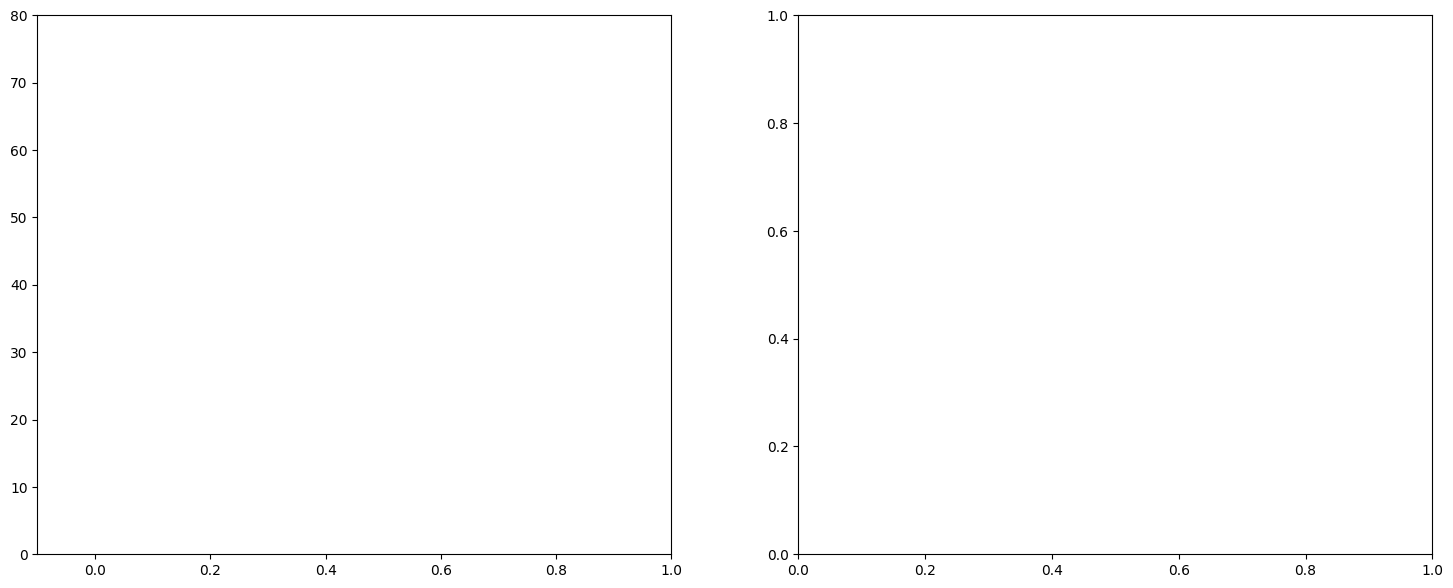

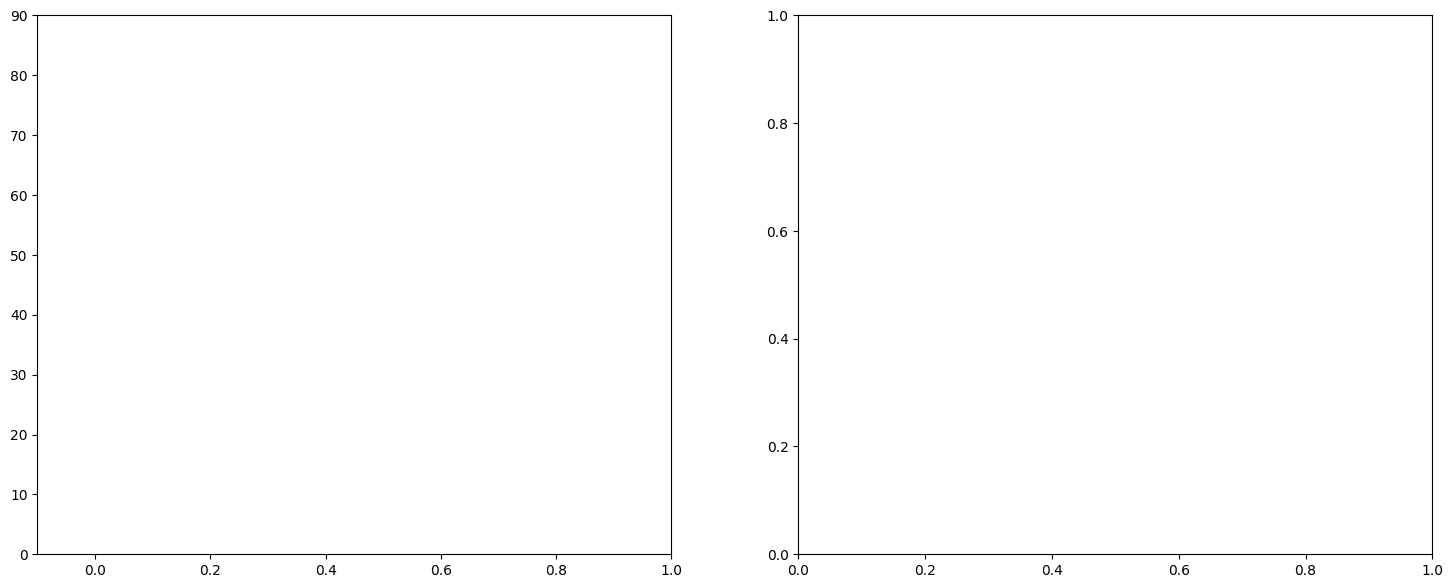

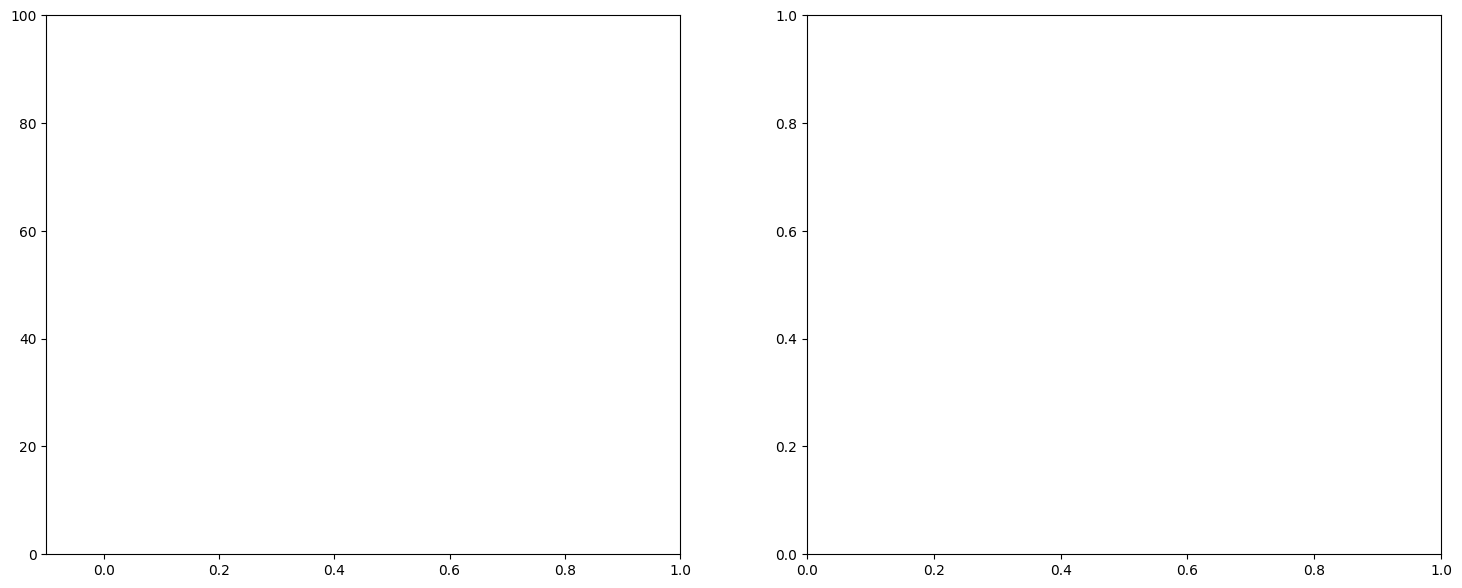

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

range_n_clusters = [2,3, 4, 5,6]


for key in data_hconcat.keys():
    print(key) 
    for n_clusters in range_n_clusters:       
        if n_clusters >= data_hconcat[key].shape[0]:
            continue

        x_=data_hconcat[key].shape[0]
        y_=data_hconcat[key].shape[1]
        test=data_hconcat[key].reshape((x_, y_))

        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(test) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=5,metric="dtw", random_state=42)
        cluster_labels = clusterer.fit_predict(test)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(test, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

    #     # Compute the silhouette scores for each sample
    #     sample_silhouette_values = silhouette_samples(test, cluster_labels)

    #     y_lower = 10
    #     for i in range(n_clusters):
    #         # Aggregate the silhouette scores for samples belonging to
    #         # cluster i, and sort them
    #         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    #         ith_cluster_silhouette_values.sort()

    #         size_cluster_i = ith_cluster_silhouette_values.shape[0]
    #         y_upper = y_lower + size_cluster_i

    #         color = cm.nipy_spectral(float(i) / n_clusters)
    #         ax1.fill_betweenx(
    #             np.arange(y_lower, y_upper),
    #             0,
    #             ith_cluster_silhouette_values,
    #             facecolor=color,
    #             edgecolor=color,
    #             alpha=0.7,
    #         )

    #         # Label the silhouette plots with their cluster numbers at the middle
    #         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    #         # Compute the new y_lower for next plot
    #         y_lower = y_upper + 10  # 10 for the 0 samples

    #     ax1.set_title("The silhouette plot for the various clusters.")
    #     ax1.set_xlabel("The silhouette coefficient values")
    #     ax1.set_ylabel("Cluster label")

    #     # The vertical line for average silhouette score of all the values
    #     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #     ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    #     # 2nd Plot showing the actual clusters formed
    #     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #     ax2.scatter(
    #         test[:, 0], test[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    #     )

    #     # Labeling the clusters
    #     centers = clusterer.cluster_centers_
    #     # Draw white circles at cluster centers
    #     ax2.scatter(
    #         centers[:, 0],
    #         centers[:, 1],
    #         marker="o",
    #         c="white",
    #         alpha=1,
    #         s=200,
    #         edgecolor="k",
    #     )

    #     for i, c in enumerate(centers):
    #         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    #     ax2.set_title("The visualization of the clustered data.")
    #     ax2.set_xlabel("Feature space for the 1st feature")
    #     ax2.set_ylabel("Feature space for the 2nd feature")

    #     plt.suptitle(
    #         "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    #         % n_clusters,
    #         fontsize=14,
    #         fontweight="bold",
    #     )

    # plt.show()

In [ ]:
# Cluster Visualization

n_clusters=[1, 2]
c_regions={}

for key in data_hconcat.keys():
    print(key)
    for n_cluster in n_clusters:
        
        if n_cluster > data_hconcat[key].shape[0]:
            # print(key, '---', n_cluster,  'clusters >=' ,data_hconcat[key].shape[0], 'regions, skipping')
            continue

        # Dataset handling
        clusters = clusterize_regions(data_hconcat[key], n_cluster, 
                                    metric="dtw", seed=10)
        print(n_cluster, 'clusters', clusters)

        c_regions[key] = clusters2region(clusters, regions_split[key])
        dataset = get_cluster_dataset(c_regions[key], cfg, data_path+'sinasc_regsaude_', res=cfg['res'])
        stacked_ds = stackg(dataset) # 0 = seq_train; 1 = seq_dev

        seq_train, seq_dev = stacked_ds[0], stacked_ds[1]

        for c in range(len(seq_train)): # (sample, serie)
            seq_dev[c] = seq_dev[c].transpose() 
        seq_train[c] = seq_train[c].transpose()
# c_regions

RS
1 clusters {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}
2 clusters {0: [8, 9, 10, 21], 1: [0, 1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]}


In [ ]:
for i in regions_path.keys():
    print(i, len(regions_path[i])) 

RS 30


In [ ]:
cfg = {
    'seed': None,
    'n_clusters': None,
    'n_preds': None,
    'n_input': None, 
    'n_output': None,
    'dev_year': "2017-01-01", 
    'test_year': None,
    'batch_size': None,
    'neuron_config': None,
    'cluster': None,
    'epochs': None,
    'loss': 'rmse'
}

epoch = 750
n_clusters = [5, 6]
# n_clusters = [2]
seeds = [10, 2507]
batch_sizes = [32, 64, 128]
neuron_1_config = list(range(50, 201, 50))
neuron_2_config = list(range(50, 201, 50))
neuron_3_config = list(range(50, 201, 50))

neuron_2_config.insert(0, 0)
neuron_3_config.insert(0, 0)

preds=[60]
windows=[24]

runs_ = 0
total = len(seeds) * len(batch_sizes) * len(neuron_1_config) * \
            len(neuron_2_config) * len(neuron_3_config) * \
                len(preds) * len(windows) * len(n_clusters)

total  

1200

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
#This will ignore all DeprecationWarning warnings in your code.

comb=0
for key in data_hconcat.keys():
    for n_cluster in n_clusters:
        for seed in seeds:
            for batch_size in batch_sizes:
                for neuron_1 in neuron_1_config:
                    for neuron_2 in neuron_2_config:
                        for neuron_3 in neuron_3_config:
                            for prediction in preds:
                                for window in windows:

                                    if comb<358:
                                        comb += 1
                                        runs_ += 1*int(n_cluster)
                                        print(f'Clusters: {n_cluster}, cluster {c}' +\
                                                  f' combination: {comb} of {total}, runs_ {runs_}') 
                                        continue
                                    
                                    if n_cluster > data_hconcat[key].shape[0]:
                                        print(key, '---', n_cluster,  'clusters >=' ,data_hconcat[key].shape[0], 'regions, skipping')
                                        continue
                            
                                    if (prediction*2) < (window*2):
                                        print(f'windowing {window} greater than the final prediction {prediction}, skipping')
                                        continue

                                    w, n_preds= window, prediction

                                    limit=2021
                                    test=int((limit)-((int(n_preds)/12)-1))

                                    test_year=f'{test}-01-01'
                                    # dev_year=f'{test-2}-01-01'

                                    cfg['test_year'] = test_year
                                    # cfg['dev_year'] = dev_year                            

                                    if (neuron_2 == 0) and (neuron_3 > 0):
                                        continue 

                                    # separating optimization by folders according to preds and windowing
                                    name_file=f'{key}_mlp_multvar_cl_{int(n_cluster)}_wind_{w}_preds_{n_preds}_test_{test_year}.csv'
                                    path_res=f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/AdrielMori/notebooks_multivariate/clusters/results/bestRes_test/monthly/opt_{key}'
                                    results_file = path_res + f'/{name_file}'
                                    
                                    os.makedirs(os.path.join(path_res), exist_ok=True)

                                    cfg['seed'] = seed
                                    cfg['epochs'] = epoch
                                    cfg['n_clusters'] = n_cluster
                                    cfg['batch_size'] = batch_size
                                    cfg['n_input'], cfg['n_output']= int(w), int(w)
                                    cfg['neuron_config'] = [neuron_1, neuron_2, neuron_3]

                                    # ## Get len pred for fortnighly resolution
                                    # _, test_df=data_concatenate(cfg, 
                                    #                             list_states_samples,
                                    #                             'M')

                                    seed_everything(cfg['seed'])
                                    for c in range(0, n_cluster): # for each cluster several {total} models will be trained  
                                        cfg['cluster'] = c
                                        cfg['n_preds']= int(prediction)

                                        seq_train, seq_dev, c_regions = get_dv_seq(cfg, data_hconcat, 
                                                                                key, cfg['n_clusters'],
                                                                                regions_split, 
                                                                                data_path,
                                                                                res='M')

                                        scaler = MinMaxScaler(feature_range=(-1,1))    
                                        scaler = scaler.fit(seq_train[c])
                                        inputs_norm = scaler.transform(seq_train[c])

                                        X, y = split_sequence(inputs_norm, 
                                                            cfg['n_input'], 
                                                            cfg['n_output'])
                                                                    
                                        n_input = X.shape[1] * X.shape[2]
                                        X_ = X.reshape((X.shape[0], n_input))

                                        n_output = y.shape[1] * y.shape[2]
                                        y_ = y.reshape((y.shape[0], n_output))
                                        
                                        model = create_model(
                                            cfg['loss'], n_input, n_output, 
                                            neuron_layer=cfg['neuron_config'])

                                        # ########################################################################
                                        # lossh = LossHistory()
                                        earlys = tf.keras.callbacks.EarlyStopping(
                                            monitor='loss', mode='min', 
                                            patience=50, verbose=0)
                                        
                                        history = model.fit(X_, y_, epochs=cfg['epochs'], 
                                                            batch_size=cfg['batch_size'], 
                                                            callbacks=[earlys],
                                                            verbose=0)

                                        _, yhat_test = inference(
                                                                model, cfg['n_input'], 
                                                                cfg['n_output'], cfg['n_preds'], 
                                                                X_, y_, seriesq=X.shape[2])

                                        # y_new = y_.reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
                                        # yhat_train = array(yhat_train).reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
                                        yhat_test = scaler.inverse_transform(
                                            yhat_test.reshape(cfg['n_preds'], X.shape[2]))

                                        initial_date, last_year= 0, 0
                                        initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
                                        last_year = initial_date.year - 1
                                        
                                        dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                                                    for i in range(cfg['n_preds'])]

                                        ep_loss = history.epoch[-1]

                                        ## Monthy resolution
                                        _, seq_dev, _ = get_dv_seq(cfg, data_hconcat, 
                                                                                key, cfg['n_clusters'],
                                                                                regions_split, 
                                                                                data_path,
                                                                                res='M')

                                        for j in range(seq_dev[c].shape[1]):      

                                            mae_test, mape_test = compute_errors(yhat_test[:, j], 
                                                                            seq_dev[c][:, j])

                                            pred_results = {}
                                            pred_results['codibge'] = c_regions[key][c][j]
                                            pred_results['mae_mlp'] = mae_test
                                            pred_results['mape_mlp'] = mape_test
                                            pred_results['ep_stop'] = ep_loss
                                            pred_results['seed'] = cfg['seed']
                                            pred_results['ep'] = cfg['epochs']
                                            pred_results['batch_size'] = cfg['batch_size']
                                            pred_results['neuron_config'] = cfg['neuron_config']
                                            pred_results['n_clusters'] = cfg['n_clusters']
                                            pred_results['cluster'] = cfg['cluster']

                                            param_keys = list(pred_results.keys()).append('model')
                                            pred_results = get_pred_df(c_regions[key][c][j], 
                                                                    'MLP_multivar', 
                                                                    last_year+1,
                                                                    int(int(n_preds)/12), 
                                                                    dict_base=pred_results)
                        
                                            start_index = list(pred_results).index(f'jan-{last_year+1}')
                                            for i, value in enumerate(yhat_test[:, j].flatten()):
                                                pred_results[list(pred_results.keys())[start_index + i]] = value

                                            if os.path.exists(results_file):
                                                results = pd.read_csv(results_file)
                                            else:
                                                results = pd.DataFrame()

                                            results = results.append(pred_results, ignore_index=True)
                                            results.to_csv(results_file, index=False)

                                            del results

                                            # save_figure(dates, seq_dev[c][:, j], yhat_test[:, j], 
                                            #             model="MultiLayer Perceptron", 
                                            #             subtitle=f"Health Region: {c_regions[c][j]}", 
                                            #             title=f"\n neurons: {cfg['neuron_config']}    batch size: {cfg['batch_size']}    " + \
                                            #                     f"epochs: {ep_loss}    seed: {cfg['seed']}   clusters: {cfg['n_clusters']}    cluster: {cfg['cluster']}" + \
                                            #                     f"\nMAE: {mae_val}   MAPE: {mape_val}", 
                                            #             fig_name=f"{figures_file}/cls{cfg['n_clusters']}_{str(c_regions[c][j])}_nr{cfg['neuron_config']}_bs{cfg['batch_size']}" +
                                            #                     f"_sd{cfg['seed']}_ep{cfg['epochs']}_cl{cfg['cluster']}", 
                                            #             show=False)

                                        print(f'Clusters: {n_cluster}, cluster {c}' +\
                                                f' combination: {comb} of {total}, runs_ {runs_}')
                                        
                                        runs_ += 1
                                    comb += 1
                                    

                    #                 break # model config
                    #             break # model config
                    #         break # model config
                    #     break # model Config 
                    # break # model config  
                
print('')

Clusters: 5, cluster 1 combination: 1 of 1200, runs_ 5
Clusters: 5, cluster 1 combination: 2 of 1200, runs_ 10
Clusters: 5, cluster 1 combination: 3 of 1200, runs_ 15
Clusters: 5, cluster 1 combination: 4 of 1200, runs_ 20
Clusters: 5, cluster 1 combination: 5 of 1200, runs_ 25
Clusters: 5, cluster 1 combination: 6 of 1200, runs_ 30
Clusters: 5, cluster 1 combination: 7 of 1200, runs_ 35
Clusters: 5, cluster 1 combination: 8 of 1200, runs_ 40
Clusters: 5, cluster 1 combination: 9 of 1200, runs_ 45
Clusters: 5, cluster 1 combination: 10 of 1200, runs_ 50
Clusters: 5, cluster 1 combination: 11 of 1200, runs_ 55
Clusters: 5, cluster 1 combination: 12 of 1200, runs_ 60
Clusters: 5, cluster 1 combination: 13 of 1200, runs_ 65
Clusters: 5, cluster 1 combination: 14 of 1200, runs_ 70
Clusters: 5, cluster 1 combination: 15 of 1200, runs_ 75
Clusters: 5, cluster 1 combination: 16 of 1200, runs_ 80
Clusters: 5, cluster 1 combination: 17 of 1200, runs_ 85
Clusters: 5, cluster 1 combination: 18 of

## Daniel Results

In [ ]:
best_res_m=['/monthly_results_cl_multvar_wind_24_preds_36_test_2019-01-01.csv',
            '/monthly_results_cl_multvar_wind_24_preds_48_test_2018-01-01.csv',
            '/monthly_results_cl_multvar_wind_36_preds_60_test_2017-01-01.csv']

best_res_f=['/fortnightly_results_cl_multvar_wind_48_preds_36_test_2019-01-01.csv',
            '/fortnightly_results_cl_multvar_wind_72_preds_48_test_2018-01-01.csv',
            '/fortnightly_results_cl_multvar_wind_48_preds_60_test_2017-01-01.csv']


In [ ]:
resolution='monthly'
path_res=f'C:/Users/Usuario/Documents/UFG_Remoto/Projects/_TSF/MS/src/results/{resolution}'

if resolution == 'fortnightly':
    list_opt=best_res_f
else:
    list_opt=best_res_m

for file in list_opt:
    
    n_steps=file.split('/')[-1].split('_')[5]
    n_pred=file.split('/')[-1].split('_')[7]
    test_year=file.split('/')[-1].split('_')[-1].split('.')[0]
    year_start=int(test_year.split('-')[0])
    
    # print(n_steps, pred, test_year)
    df_results=pd.read_csv(path_res + file)
    
    num_years=int(int(n_pred)/12)
    name_file=f'preds_{num_years}_years_2022-01-01_test.csv'
    results_file = f'C:/Users/Usuario/Documents/UFG_Remoto/Projects/_TSF/MS/src/results/{resolution}/{name_file}'
    
    for row, info in df_results.iterrows():
        
        codibge=int(info['codibge'])

        cfg = {
        'seed': int(info['seed']),
        'n_clusters': int(info['n_clusters']),
        'n_preds': int(n_pred),
        'n_input': int(n_steps), 
        'n_output': int(n_steps),
        'dev_year': '2017-01-01', 
        'test_year': '2022-01-01',
        'batch_size': int(info['batch_size']),
        'neuron_config': get_neurons(info['neuron_config']),
        'cluster': int(info['cluster']),
        'epochs': int(info['ep']),
        'loss': 'rmse'
        }

        # data_hconcat=get_data_concat(cfg)
        seq_train, seq_dev, c_regions = get_dv_seq(cfg,
                                                list_states_samples, 
                                                regions_split, 
                                                data_path,
                                                res='M')

        # epoch = 500
        n_clusters = int(info['n_clusters'])
        # seeds = [10, 3407]
        # batch_sizes = [32, 64]
        # neuron_1_config = cfg['neuron_config'][0]
        # neuron_2_config = cfg['neuron_config'][1]
        # neuron_3_config = cfg['neuron_config'][2]

        # neuron_2_config.insert(0, 0)
        # neuron_3_config.insert(0, 0)

        seed_everything(cfg['seed'])
        c=cfg['cluster']

        scaler = MinMaxScaler(feature_range=(-1,1))    
        scaler = scaler.fit(seq_train[c])
        inputs_norm = scaler.transform(seq_train[c])

        X, y = split_sequence(inputs_norm, 
                            cfg['n_input'], 
                            cfg['n_output'])
                                    
        n_input = X.shape[1] * X.shape[2]
        X_ = X.reshape((X.shape[0], n_input))

        n_output = y.shape[1] * y.shape[2]
        y_ = y.reshape((y.shape[0], n_output))
        
        model = create_model(
                        cfg['loss'], n_input, n_output, 
                        neuron_layer=cfg['neuron_config'])

        # ########################################################################
        # lossh = LossHistory()
        earlys = tf.keras.callbacks.EarlyStopping(
            monitor='loss', mode='min', 
            patience=15, verbose=0)
        
        history = model.fit(X_, y_, epochs=cfg['epochs'], 
                            batch_size=cfg['batch_size'], 
                            callbacks=[earlys],
                            verbose=0)

        _, yhat_test = inference(
                            model, cfg['n_input'], 
                            cfg['n_output'], cfg['n_preds'], 
                            X_, y_, seriesq=X.shape[2])

        # y_new = y_.reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
        # yhat_train = array(yhat_train).reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
        yhat_test = scaler.inverse_transform(
            yhat_test.reshape(cfg['n_preds'], X.shape[2]))

        initial_date, last_year= 0, 0
        initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
        last_year = initial_date.year - 1
        
        dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                    for i in range(cfg['n_preds'])]

        ep_loss = history.epoch[-1]

        for j in range(seq_dev[c].shape[1]):
            if c_regions[c][j] != str(codibge):
                continue
            # mae_val, mape_val = compute_errors(yhat_test[:, j], 
            #                                 seq_dev[c][:, j])

            pred_results = {}
            # pred_results['codibge'] = c_regions[c][j]
            # pred_results['mae_mlp_mult'] = mae_val
            # pred_results['mape_mlp_mult'] = mape_val
            # pred_results['ep_stop'] = ep_loss
            # pred_results['seed'] = cfg['seed']
            # pred_results['ep'] = cfg['epochs']
            # pred_results['batch_size'] = cfg['batch_size']
            # pred_results['neuron_config'] = cfg['neuron_config']
            # pred_results['n_clusters'] = cfg['n_clusters']
            # pred_results['cluster'] = cfg['cluster']

            param_keys = list(pred_results.keys()).append('model')
            pred_results = get_pred_df(c_regions[c][j], 
                                    'MLP_multivar', 
                                    last_year+1,
                                    int(cfg['n_preds']/12), 
                                    dict_base=pred_results)

            start_index = list(pred_results).index(f'jan-{last_year+1}')
            for i, value in enumerate(yhat_test[:, j].flatten()):
                pred_results[list(pred_results.keys())[start_index + i]] = value
                
            # print(pred_results)

            if os.path.exists(results_file):
                results = pd.read_csv(results_file)
            else:
                results = pd.DataFrame()
            
            print(results)

            results = results.append(pred_results, ignore_index=True)
            results.to_csv(results_file, index=False)

    df_results.rename(columns={'mape_mlp': f'mape_mlp_{year_start}-2021',
                      'mae_mlp': f'mae_mlp_{year_start}-2021'},
                        inplace=True)
    
    df_results = df_results.drop(
      columns = [
          'Unnamed: 0',
        #   'mae_mlp_SMS',
        #   'mape_mlp_SMS',
        #   'mape_mlp_M',
        #   'mape_mlp_M',
          'ep_stop',
          'seed', 'ep',
          'batch_size', 
          'neuron_config',
          'n_clusters',
          'cluster'
      ]
    )
    
    result=pd.concat([df_results, results], axis=1)
    print(result.columns)
    # results = results.append(pred_results, ignore_index=True)
    result.to_csv(path_res+f'/preds_{num_years}_years_2022-01-01.csv', index=False)
    # break
          
    

## Optimization

In [ ]:
#Window opt

for prediction in [24, 36, 48, 60]:
  for window in [24, 36, 48, 60]:

      if prediction < window:
        print(f'windowing {window} greater than the final prediction {prediction}, skipping')
        continue

      windown, n_preds= window, prediction

      limit=2021
      test=int((limit)-((int(n_preds)/12)-1))

      test_year=f'{test}-01-01'
      dev_year=f'{test-2}-01-01'

      name_file=f'mlp_multvar_wind_{windown}_preds_{n_preds}_dev_{dev_year}_test_{test_year}.csv'
      results_file = f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/AdrielMori/notebooks_multivariate/clusters/bestRes_test/{name_file}'
      # figures_file = f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/ricardo/experimentos/figures/mlp_{v}_multvar'

      # ! rm -f $results_file
      # ! rm -rf $figures_file/*

      # os.makedirs('/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/ricardo/experimentos', exist_ok=True)
      # os.makedirs(figures_file, exist_ok=True)

      for row, info in df_results.iterrows():
        
        codibge=int(info['codibge'])

        cfg = {
          'seed': int(info['seed']),
          'n_clusters': int(info['n_clusters']),
          'n_preds': n_preds,
          'n_input': windown, 
          'n_output': windown,
          'dev_year': dev_year, 
          'test_year': test_year,
          'batch_size': int(info['batch_size']),
          'neuron_config': get_neurons(info['neuron_config']),
          'cluster': int(info['cluster']),
          'epochs': int(info['ep']),
          'loss': 'rmse'
        }

        # data_hconcat=get_data_concat(cfg)
        seq_train, seq_dev, c_regions = get_dv_seq(cfg)

        # epoch = 500
        n_clusters = int(info['n_clusters'])
        # seeds = [10, 3407]
        # batch_sizes = [32, 64]
        # neuron_1_config = cfg['neuron_config'][0]
        # neuron_2_config = cfg['neuron_config'][1]
        # neuron_3_config = cfg['neuron_config'][2]

        # neuron_2_config.insert(0, 0)
        # neuron_3_config.insert(0, 0)

        seed_everything(cfg['seed'])
        c=cfg['cluster']

        scaler = MinMaxScaler(feature_range=(-1,1))    
        scaler = scaler.fit(seq_train[c])
        inputs_norm = scaler.transform(seq_train[c])

        X, y = split_sequence(inputs_norm, 
                            cfg['n_input'], 
                            cfg['n_output'])
                                    
        n_input = X.shape[1] * X.shape[2]
        X_ = X.reshape((X.shape[0], n_input))

        n_output = y.shape[1] * y.shape[2]
        y_ = y.reshape((y.shape[0], n_output))
        
        model = create_model(
                        cfg['loss'], n_input, n_output, 
                        neuron_layer=cfg['neuron_config'])

        # ########################################################################
        # lossh = LossHistory()
        earlys = tf.keras.callbacks.EarlyStopping(
            monitor='loss', mode='min', 
            patience=15, verbose=0)
        
        history = model.fit(X_, y_, epochs=cfg['epochs'], 
                            batch_size=cfg['batch_size'], 
                            callbacks=[earlys],
                            verbose=0)

        _, yhat_test = inference(
            model, cfg['n_input'], 
            cfg['n_output'], cfg['n_preds'], 
            X_, y_, seriesq=X.shape[2])

        # y_new = y_.reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
        # yhat_train = array(yhat_train).reshape(-1, cfg['n_preds'], X.shape[2])[:,0,:]
        yhat_test = scaler.inverse_transform(
            yhat_test.reshape(cfg['n_preds'], X.shape[2]))

        initial_date, last_year= 0, 0
        initial_date = datetime.datetime.strptime(cfg['test_year'], '%Y-%d-%m')
        last_year = initial_date.year - 1
        
        dates = [(initial_date + relativedelta(months=i)).strftime('%m-%Y') 
                    for i in range(cfg['n_preds'])]

        ep_loss = history.epoch[-1]

        for j in range(seq_dev[c].shape[1]):
            if c_regions[c][j] != str(codibge):
              continue
            mae_val, mape_val = compute_errors(yhat_test[:, j], 
                                            seq_dev[c][:, j])

            pred_results = {}
            pred_results['codibge'] = c_regions[c][j]
            pred_results['mae_mlp_mult'] = mae_val
            pred_results['mape_mlp_mult'] = mape_val
            pred_results['ep_stop'] = ep_loss
            pred_results['seed'] = cfg['seed']
            pred_results['ep'] = cfg['epochs']
            pred_results['batch_size'] = cfg['batch_size']
            pred_results['neuron_config'] = cfg['neuron_config']
            pred_results['n_clusters'] = cfg['n_clusters']
            pred_results['cluster'] = cfg['cluster']

            param_keys = list(pred_results.keys()).append('model')
            pred_results = get_pred_df(c_regions[c][j], 
                                    'MLP_multivar', 
                                    last_year+1,
                                    int(int(n_preds)/12), 
                                    dict_base=pred_results)

            start_index = list(pred_results).index(f'jan-{last_year+1}')
            for i, value in enumerate(yhat_test[:, j].flatten()):
                pred_results[list(pred_results.keys())[start_index + i]] = value

            if os.path.exists(results_file):
                results = pd.read_csv(results_file)
            else:
                results = pd.DataFrame()

            # results = results.append(pred_results, ignore_index=True)
            # results.to_csv(results_file, index=False)

            del results

            # save_figure(dates, seq_dev[c][:, j], yhat_test[:, j], 
            #             model="MultiLayer Perceptron", 
            #             subtitle=f"Health Region: {c_regions[c][j]}", 
            #             title=f"\n neurons: {cfg['neuron_config']}    batch size: {cfg['batch_size']}    " + \
            #                     f"epochs: {ep_loss}    seed: {cfg['seed']}   clusters: {cfg['n_clusters']}    cluster: {cfg['cluster']}" + \
            #                     f"\nMAE: {mae_val}   MAPE: {mape_val}", 
            #             fig_name=f"{figures_file}/cls{cfg['n_clusters']}_{str(c_regions[c][j])}_nr{cfg['neuron_config']}_bs{cfg['batch_size']}" +
            #                     f"_sd{cfg['seed']}_ep{cfg['epochs']}_cl{cfg['cluster']}", 
            #             show=False)

        # print(f'Clusters: {n_cluster}, cluster {c}' +\
        #         f' combination: {comb} of {total}, runs_ {runs_}')
        # pprint.pprint(pred_results)

        break

## Best resutls generation

In [ ]:
regions_split.keys()

In [ ]:
import pandas as pd


opt={}
for key in regions_split.keys():
  v = 1
  print(key)
  resolution='monthly'
  path_res=f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/AdrielMori/notebooks_multivariate/clusters/results/bestRes_test/{resolution}'
  results_file = path_res+f'/opt_{key}/*.csv'
  figures_file = path_res+f'/figures/mlp_{v}_multvar'

  results={}
  os.makedirs(os.path.join(figures_file), exist_ok=True)
  files=glob.glob(results_file)

  for i in files:
    name=i.split('/')[-1].split('_')[2:]
    name='_'.join(name)
    
    results[name]=pd.read_csv(i)
  opt[key]=results

In [ ]:
import pandas as pd

v = 1
resolution='monthly'
path_res=f'C:/Users/Usuario/Documents/UFG_Remoto/Projects/_TSF/MS/src/results/{resolution}'
results_file = path_res+f'/opt/*.csv'
figures_file = path_res+f'/figures/mlp_{v}_multvar'

results={}
os.makedirs(os.path.join(figures_file), exist_ok=True)
files=glob.glob(results_file)

for i in files:
  name=i.split('/')[-1].split('_')[2:]
  name='_'.join(name)
  
  results[name]=pd.read_csv(i)

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

regions=([1., 2., 3., 4., 5.])
for i in opt.keys():
  for key in opt[i].keys():
    # for c in regions:
        c = key.split('_')[2]

        if 'n_clusters' in opt[i][key]:
          bst = opt[i][key][opt[i][key]['n_clusters'] == float(c)]
          reg = bst['codibge'].unique()

          res = pd.DataFrame()
          for r in reg:
              bst_r = bst[bst['codibge'] == r].sort_values(by=['mape_mlp'], ignore_index=True)
              res = res.append(bst_r.iloc[0], ignore_index=True)

          res.to_csv(path_res+f'/{resolution}_results_cl_{c}_{i}.csv')
          display(res)
          # break
      #     t = t.append(bst.iloc[0], ignore_index=True)

    # regions

In [ ]:
results_replic

In [ ]:
import pandas as pd
resolution='monthly'
path_res=f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/AdrielMori/notebooks_multivariate/clusters/results/bestRes_test/{resolution}/'
results_replic=glob.glob(path_res+'/*.csv')

for reg in opt.keys():
  print(reg)

  results_replic=glob.glob(path_res+f'*{reg}.csv')
  for c in results_replic:
      results_multivar = pd.read_csv(c)

      if 'mape_mlp' in results_multivar.columns :
        print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp'])}")

      # display(results_multivar)
# line='-'*100
# print(line)

# for c in results_replic: 
#     results_multivar = pd.read_csv(c)

#     print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp_SMS'])}") 

In [ ]:
import pandas as pd
resolution='monthly'
path_res=f'/content/drive/Shareddrives/MS/case_nascidos/notebooks/regioes_multivariate/AdrielMori/notebooks_multivariate/clusters/results/bestRes_test/{resolution}/'
results_replic=glob.glob(path_res+'/*.csv')

for reg in opt.keys():
  print(reg)

  results_replic=glob.glob(path_res+f'*{reg}.csv')
  for c in results_replic:
      print(reg)
      results_multivar = pd.read_csv(c)

      if 'mape_mlp' in results_multivar.columns :
        print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp'])}")

      display(results_multivar)
# line='-'*100
# print(line)

# for c in results_replic: 
#     results_multivar = pd.read_csv(c)

#     print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp_SMS'])}") 

In [ ]:
Simport pandas as pd
resolution='fortnightly'
path_res=f'C:/Users/Usuario/Documents/UFG_Remoto/Projects/_TSF/MS/src/results/{resolution}'
results_replic=glob.glob(path_res+'/*.csv')
for c in results_replic:
    results_multivar = pd.read_csv(c)

    print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp_M'])}")

# line='-'*100
# print(line)

# for c in results_replic: 
#     results_multivar = pd.read_csv(c)

#     print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp_SMS'])}") 

In [ ]:
import matplotlib.pyplot as plt

for c in results_replic:
    results_multivar = pd.read_csv(c)

    # print(f"Cluster {c.split('/')[-1]} mean MAPE {np.mean(results_multivar['mape_mlp_mult'])}")
    # break

    if '2021' in c.split('/')[-1]:
      continue

    legends={52001 :'Central',
          52002 :'South-Center',
          52003 :'North Surroundings',
          52004 :'South Surroundings',
          52005 :'Estrada de Ferro',
          52006 :'Northeast I',
          52007 :'Northeast II',
          52008 :'North',
          52009 :'West I',
          52010 :'West II',
          52011 :'Pirineus',
          52012 :'Rio Vermelho',
          52013 :'São Patrício I',
          52014 :'Serra da Mesa',
          52015 :'Southwest I',
          52016 :'Southwest II',	
          52017 :'South',
          52018 :'São Patrício II'
    }

    results_multivar = results_multivar.drop(
      columns = [
          'Unnamed: 0',
          'mae_mlp_M', 
          'mape_mlp_M',
          'mae_mlp_SMS', 
          'mape_mlp_SMS',
          'ep_stop',
          'seed', 'ep',
          'batch_size', 
          'neuron_config',
          'n_clusters',
          'cluster'
      ]
    )

    n_steps=c.split('/')[-1].split('_')[5]
    pred=c.split('/')[-1].split('_')[7]
    dev_year=c.split('/')[-1].split('_')[9]
    test_year=c.split('/')[-1].split('_')[-1].split('.')[0]

    seq_dev = {}
    seq_train = {}
    seq_test = {}
    lmu_preds = {}
    mult_var_preds = {}

    regs = []
    for idx, reg in enumerate(list(results_multivar['codibge'].values)):
        regs.append(int(reg))
        path = (
            data_path
            + "/sinasc_regsaude_"
            + str(int(reg))
            + "_dia-mes-ano.csv"
        )
        dev_year = dev_year
        test_year = test_year
        n_steps = n_steps

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            traindev_df, dev_df, traintest_df, test_df = get_dataset(
                path, dev_year, test_year, res='M'
            )

        seq_test[reg] = test_df["NASCIDOS"].values
        # seq_train[reg] = traintest_df["NASCIDOS"].values
        # seq_dev[reg] = dev_df["NASCIDOS"].values

        # lmu_preds[reg] = lmu_pred[lmu_pred["codibge"] == int(reg)].drop(columns=["codibge"]).values[0,:]
        mult_var_preds[reg] = results_multivar[results_multivar["codibge"] == int(reg)].drop(columns=["codibge"]).values[0,:]
        # seq_train[reg] = seq_train[reg].reshape((len(seq_train[reg]), 1))
        # seq_dev[reg] = seq_dev[reg].reshape((len(seq_dev[reg]), 1))

    ## Plot Phase
    regs=list(results_multivar['codibge'].values)
    lines=6
    cols=3
    x = list(range(0,int(pred),1))

    fig, axs = plt.subplots(
            lines, cols, figsize=(18, 25), constrained_layout=False,
        )

    freq_leg={'24': 2,
              '36': 4, 
              '48': 6, 
              '60': 8}

    
    # t=list(range(252-24,252,1))
    # d=list(range(252-48,252-24,1))
    # sq=list(range(0,252,1))
    #n=seq_train[reg].shape[0]+seq_dev[reg].shape[0]+seq_test[reg].shape[0]
    font_size=18

    # {test_year.split('-')[0]}
    end=(int(test_year.split('-')[0]))+((int(pred)/12)-1)
    labels_x = pd.date_range(start = test_year, end =f"{int(end)}-12-31", freq=f'{freq_leg[str(pred)]}M')   
    labels_x = labels_x.strftime('%m/%Y')

    labels_series = pd.date_range(start = '2000-01-01', end =f"2022-12-31", freq=f'{freq_leg[str(pred)]}M')   
    labels_series = labels_series.strftime('%m/%Y')

    line_width = 2.5

    range_plt = np.zeros((lines, cols), dtype=np.float64)

    plt.rcParams["axes.grid"] = False
    plt.rcParams['font.size'] = f'{font_size}'

    for (rowcol, _), (idx, reg) in zip(np.ndenumerate(range_plt), enumerate(regs)):
        # print(rolcol, idx, reg)
        def plot_(axs, rowcol, idx, x, y_real, y_test, title, freq_leg, font_size, labels_x, conf):
            ci = conf * np.std(y_real) / np.sqrt(len(y_real))
            axs[rowcol].plot(x,y_real, label='Real', linewidth=line_width, linestyle="--")
            axs[rowcol].plot(x,y_test, label='Predicted', linewidth=line_width,)
            axs[rowcol].fill_between(x, (y_real - ci), (y_real + ci), color='b', alpha=.1)
            axs[rowcol].set_title(title, fontsize=font_size, fontweight="bold",)
            axs[rowcol].set_xticks(range(0, int(pred), freq_leg), labels_x, rotation=45)
            axs[rowcol].grid(False)

            plt.rcParams['font.size'] = f'{font_size}'

        #plot_(axs, rowcol, idx, x, seq_test[reg], lmu_preds[reg], legends[reg], freq_leg, font_size, labels_x, 1.95)
        plot_(axs, rowcol, idx, x, seq_test[reg], mult_var_preds[reg], legends[reg], freq_leg[str(pred)], font_size, labels_x, 1.95)


    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(
        handles, labels, loc="lower center", bbox_to_anchor=(0.5, 1), fontsize=18
    )
    plt.tight_layout()
    plt.subplots_adjust(hspace=.6, wspace=0.16)

    img_name=c.split('\\')[-1]
    # results_path=results_file.split('/')[:-1]
    # results_path='/'.join(results_path)
    
    print(img_name)
        
    # plt.savefig(
    #     os.path.join(figures_file+f'/{img_name}.png'),
    #     dpi=300,
    #     bbox_inches="tight",
    # )